# NB3. Forecasting Philippine Trade Activity using local and global forecasting models: Deep Learning Models

#### Borromeo, Castanares, Garcia, Tan

`"You never know what's going to work. You just go with what you believe in, whether it's a success or not."-Dave Brubeck, Jazz Musician`


## 1.0 Multi-task learning Models

Now that we have established a baseline of Statistical and Machine Learning models, we try to use Deep Learning models on the dataset to determine if they offer improvements in terms of forecasting performance. For this we will use the **DeepAR**, **Temporal Fusion Transformer (TFT)** and  **Patch Time Series Transformer** models. 


DeepAR is our baseline MTL model, TFT is chosen because it supports both historical and future exogenous variables, and PatchTST is chosen to represent probabilistic sequence models that do not support historical exogenous variables.

----


### 1.1 DeepAR by Salinas, Flunkert, and Gasthaus (2020)

**DeepAR** (Deep AutoRegressive) is a probabilistic forecasting model developed by Amazon that leverages recurrent neural networks (RNNs), particularly LSTMs, to learn and forecast multiple related time series together.  

**Architecture Flow**:

The simplified architecture typically follows this flow:
* Input Layer
  - Accepts past values of the target series (`y_t`).  
  - Integrates static categorical features (`cat`) and dynamic time-dependent features (`dynamic_feat`).  

* Embedding Layers
  - Categorical features are embedded into dense vectors to capture group-level patterns.  

* LSTM (or RNN) Layers
  - Processes sequences in an autoregressive manner:  
    At each time step, the model uses previous actual or predicted values as inputs to generate the next forecast.  

* Output (Likelihood) Layers
  - Maps the final hidden state to parameters of a chosen probability distribution (e.g., mean and variance of Gaussian).  
  - Enables generation of probabilistic forecasts and quantiles through sampling or direct likelihood predictions.  

**Reference**:

Salinas, D., Flunkert, V., Gasthaus, J., and Januschowski, T. (2020). "DeepAR: Probabilistic forecasting with autoregressive recurrent networks". International Journal of Forecasting, Vol. 36. Issue 3. 

### 1.1 Temporal Fusion Transformer (TFT)

**Temporal Fusion Transformer (TFT)** is a deep learning architecture designed for **interpretable multi-horizon time series forecasting**. It combines the strengths of sequence models (LSTMs) with the power of **multi-head attention** to capture both short-term temporal dynamics and long-term dependencies.

TFT also integrates rich feature sets such as:
- **Static covariates** (e.g., country, product ID)  
- **Time-varying known inputs** (e.g., holidays, planned promotions)  
- **Time-varying observed inputs** (e.g., past demand, weather)  

This allows TFT to adaptively select relevant features and generate accurate forecasts while maintaining interpretability.

**Architecture Flow**

* Input Processing
    - **Embedding layers** for categorical static/time-varying features.  
    - **Variable selection networks** dynamically choose which covariates matter at each time step.  

* Local Processing
    - **Gated Residual Networks (GRN)** process the selected features.  
    - **LSTM encoder-decoder** captures short-term sequential patterns.  

* Long-Term Dependency Modeling
    - **Multi-head attention layer** focuses on important time steps across the history window.  

* Output Layer
    - Combines LSTM outputs and attention context.  
    - Produces probabilistic forecasts (e.g., quantiles) via likelihood-based loss functions.  

**Key Advantages**
- **Interpretability** → attention weights + variable selection networks show which features/timesteps mattered most.  
- **Multi-horizon forecasts** → forecasts a full trajectory instead of step-by-step autoregression.  
- **Flexibility** → handles static, known, and observed covariates seamlessly.  

**Reference**:

Lim, B., Arik, S., Loeff, N, and Pfister, T. (2021). "Temporal Fusion Transformers for interpretable multi-horizon time series forecasting". International Journal of Forecasting, Vol. 37. Issue 4. https://doi.org/10.1016/j.ijforecast.2021.03.012.

### 1.3 PatchTST (Patch Time Series Transformer)

**PatchTST**, introduced by Yuqi Nie, Nam H. Nguyen, Phanwadee Sinthong, and Jayant Kalagnanam (ICLR 2023), proposes an efficient and powerful design for long-term multivariate time series forecasting by combining two key innovations:
- **Patching**: Dividing each univariate time series into subseries-level patches, which serve as tokens for the Transformer, reducing sequence length and preserving local semantic structure.
- **Channel independence**: Treating each variable (channel) independently using the same Transformer backbone and embeddings, allowing shared learning while avoiding cross-channel interference.:contentReference[oaicite:2]{index=2}  

**Architecture Overview**

The model operates as follows:
1. **Per-channel Processing**: A multivariate time series is split into individual channels. Each channel is independently normalized and processed through the shared Transformer backbone.  
2. **Patching + Embedding**: Each univariate sequence is segmented into patches (of length _P_, with stride _S_), then projected and position-encoded to form Transformer inputs.  
3. **Transformer Encoding**: A standard multi-head self-attention Transformer encoder processes each set of patches.  
4. **Prediction Head**: Output embeddings are flattened and passed through a linear head to generate the final forecast for each channel.  
5. **Optional Self-Supervised Learning**: Masked patches can be used for self-supervised pre-training (reconstruction tasks)


**Reference**:

Nie, Y., Nguyen, N., Sinthong, P., Kalagnanam, J. (2022). "A Time Series is Worth 64 Words: Long-Term Forecasting with Transformers". ArXiv. https://arxiv.org/abs/2211.14730

## 2.0 MTL Codes

In the next few sections, we explore the performance of different MTL models given a set of time-series inputs/tasks. We vary the set of inputs/tasks as follows:

* 2.2: **All-to-one**. All time series (Import, Exports, FX). Vanilla MTL models (without Engineered Features)
    - outputs: 
        - All Timeseries on PHL Exports, 
        - All Timeseries on PHL Imports
* 2.3: **Import and Export in isolation**. We generate two MTL models that for all Import and Export series, separately.
    - outputs: 
        - Exports only
        - Imports only
* 2.4: **Import and Export plus Add Exogenous Variable: USD/PHP**
    - We add USD/PHP forex data into the time series features. The reasoning here is that imports/export could be correlated with the USD since international trade transactions are usually settled in USD, and a country's local currency strength agains the USD could be a factor in its import and export volumes. 
    - outputs: 
        - Exports only With Forex,
        - Imports only With Forex
* 2.5: **Import and Export with Top 4 Trading Partner**. 
    - We consider only the top 4 countries that the Philippines does imports and exports with (i.e., Hongkong, Japan, China, Singapore). The reasoning here is that these countrues could have more of a correlation with the Philippines' imports and exports since they have stronger relationships with the country.
    - outputs: 
        - Top 4 Imports Only with Forex
        - Top 4 Exports Only with Forex 
* 2.6: **Import and Export With Top4 Trading Partner Countries plus FX(PHP/USD only)**
    - outputs: 
        - All Timeseries With Fourier Terms and Forex on PHL Imports
        - All Timeseries With Fourier Terms and Forex on PHL Exports
        - Top 4 Imports Only with Fourier Terms
        - Top 4 Exports Only with Fourier Terms
        - Top 4 Imports Only with Fourier Terms and Forex
        - Top 4 Exports Only with Fourier Terms and Forex



In [ ]:
%%capture
# !pip install tsfeatures
# !pip install datasetsforecast

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from utilsforecast.plotting import plot_series

import os


import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    DIR = '/content/drive/MyDrive/AIM/Timeseries/FinalProject'
else:
    DIR = '.'

plt.style.use("ggplot")

plt.rcParams.update({
    "figure.figsize": (10, 4),
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
})

pd.set_option("display.precision", 3)
np.set_printoptions(suppress=True)

### 2.1 Data loading
We load the Import/Export data and view a sample of the training data 

In [ ]:
### Consolidate Import and Export data
DAT_Export = pd.read_csv(f'{DIR}/data/SPGlobal_Exports_clean.csv',
                         parse_dates=['ds'])
DAT_Export.dropna(axis=0, inplace=True)
DAT_Export.columns = [f'{x}_export' if x != 'ds' else x for x in DAT_Export.columns]
DAT_Export = DAT_Export.melt(id_vars=['ds'], var_name='unique_id', value_name='y', ignore_index=True)


DAT_Import = pd.read_csv(f'{DIR}/data/SPGlobal_Imports_clean.csv', parse_dates=['ds'])
DAT_Import.dropna(axis=0, inplace=True)
DAT_Import.columns = [f'{x}_import' if x != 'ds' else x for x in DAT_Import.columns]
DAT_Import = DAT_Import.melt(id_vars=['ds'], var_name='unique_id', value_name='y', ignore_index=True)

DAT = pd.concat([DAT_Export, DAT_Import], axis=0)
DAT[DAT.ds > '2023-12-01'].reset_index(drop=True).to_csv(f'{DIR}/TEST.csv')
DAT[DAT.ds <= '2023-12-01'].reset_index(drop=True).to_csv(f'{DIR}/TRAIN.csv')

DAT_TRAIN = pd.read_csv(f'{DIR}/TRAIN.csv', parse_dates=['ds'],index_col=0)
DAT_TEST = pd.read_csv(f'{DIR}/TEST.csv', parse_dates=['ds'],index_col=0)

custom_colors = ["black", "tab:blue"]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)
# plot_series(DAT_TRAIN,
#             DAT_TEST)
plot_series(DAT_TRAIN)


### 2.2 All-to-one: All time series (Import, Exports, FX)

Here we test the vanilla Deep Learning models. These models are available under NIXTLA's Neuralforecast package.

We investigate whether a global ML model can forecast the import and export activity. In particular, we assess whether a global model, with cross-learning, can out-perform local models trained for specific dataset.

Model A is a collection of vanilla models DeepAR / TFT / PatchTST using the import and export volumes as inputs (without introducing any engineered features)

In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.models import DeepAR, TFT, PatchTST #TFT, NBEATS, TimeGPT
from neuralforecast.losses.pytorch import DistributionLoss
from neuralforecast.losses.pytorch import MQLoss  # Import a compatible loss
import torch
import time
torch.set_float32_matmul_precision('medium')

### CV parameters
h = 6
n_windows = 3  # Number of cross-validation folds
step_size = 3
test_size = 6


models = [
    DeepAR(h=h,
            input_size=2*h, #when predicting h, lookback 2*h
            max_steps=1000,
            scaler_type='robust',
            trajectory_samples=200,
            loss=DistributionLoss(distribution='StudentT', level=[80, 95]),
            lstm_n_layers=2, #By default this is 1
            lstm_hidden_size=64,
            decoder_hidden_layers=2, #MLP layers, we force it. Be default = 0, linear layer
            decoder_hidden_size=64, 
            ),
    TFT(
            h=h,
            input_size=2*h,
            hidden_size=128,
            n_head=4,
            loss=DistributionLoss(distribution='StudentT', level=[80, 95]),
            max_steps=400,  # keep small while testing
        ), 
    PatchTST(
            h=h,
            input_size=4*h,
            max_steps=500,
            batch_size=32,
            hidden_size=64,
            n_heads=4,
            patch_len=16,
            stride=8,
            loss=DistributionLoss(distribution='Normal', level=[80, 95]),
            scaler_type='standard'
    )             
]
nf = NeuralForecast(models=models, freq='M')
# nf.fit(df=DAT_TRAIN)

Seed set to 1
Seed set to 1
Seed set to 1


In [ ]:
#### Cross-validation
start = time.time()
cv_df = nf.cross_validation(
    df=DAT_TRAIN,
    n_windows=n_windows,
    # test_size=test_size,
    step_size=step_size, # This ensures non-overlapping test sets
    refit=False # Set to True to retrain the model on each new window, but this is much slower
)
print(f'Elapsed time: {time.time() - start:.2f} seconds')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | valid_loss   | MAE              | 0      | train
2 | padder_train | ConstantPad1d    | 0      | train
3 | scaler       | TemporalNorm     | 0      | train
4 | hist_encoder | LSTM             | 50.4 K | train
5 | decoder      | Decoder          | 4.4 K  | train
----------------------------------------------------------
54.8 K    Trainable params
5         Non-trainable params
54.8 K    Total params
0.219     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K     Total params
3.482     Total estimated mo

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | DistributionLoss  | 5      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 153 K  | train
-----------------------------------------------------------
153 K     Trainable params
8         Non-trainable params
153 K     Total params
0.614     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
from neuralforecast.losses.numpy import mase, mae

# Calculate Mean Absolute Error (MAE) for each model
# Note: For DeepAR's DistributionLoss, MAE is calculated from the mean of the distribution
deepar_mae = mae(cv_df['y'].values, cv_df['DeepAR'].values)
tft_mae = mae(cv_df['y'].values, cv_df['TFT'].values)
ptst_mae = mae(cv_df['y'].values, cv_df['PatchTST'].values)

print(f"DeepAR Average MAE: {deepar_mae:.4f}")
print(f"TFT Average MAE: {tft_mae:.4f}")
print(f"PatchTST Average MAE: {ptst_mae:.4f}")


DeepAR Average MAE: 183.2846
TFT Average MAE: 189.4539
PatchTST Average MAE: 156.5253


As we can see, PatchTST performs best for the general model wih all import/export data. Let's use it to do our forecasting:

In [ ]:
#### Forecast the test set
h = len(DAT_TEST.ds.unique()) + 1

models = [
    PatchTST(
        h=h,
        input_size=4*h,
        max_steps=500,
        batch_size=32,
        hidden_size=64,
        n_heads=4,
        patch_len=16,
        stride=8,
        loss=DistributionLoss(distribution='Normal', level=[80, 95]),
        scaler_type='standard'
    )
       
    ]

nf = NeuralForecast(models=models, freq='M')
nf.fit(df=DAT_TRAIN)

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | DistributionLoss  | 5      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 167 K  | train
-----------------------------------------------------------
167 K     Trainable params
8         Non-trainable params
167 K     Total params
0.672     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.


In [9]:
from functools import partial
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse, mae, mape as _mape, mase, rmsse

df_f = nf.predict() # Forecast!
df_f["ds"] = pd.to_datetime(df_f["ds"]).dt.to_period("M").dt.to_timestamp()
df_f = pd.merge(DAT_TEST, df_f, on=['ds', 'unique_id']) # append ground truth "y"

def mape(df, models, id_col="unique_id", target_col="y"):
    df_mape = _mape(df, models, id_col=id_col, target_col=target_col)
    df_mape.loc[:, df_mape.select_dtypes(include='number').columns] *= 100
    return df_mape


df_eval = evaluate(df_f, 
                   metrics=[mae, rmse, mape, partial(mase, seasonality=12),
                                   partial(rmsse, seasonality=12)],
                   train_df=DAT_TRAIN) # mase uses snaive as scaler
# df_eval.pivot(index='unique_id', columns='metric', values='DeepAR')
df_eval.pivot(index='unique_id', columns='metric', values=['PatchTST'])

/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

PatchTST                                
metric           mae    mape   mase      rmse  rmsse
unique_id                                           
AUS_export   104.708   6.607  0.579   134.163  0.589
AUS_import   201.646  14.173  1.783   216.422  1.514
CHN_export  1651.430  10.303  1.424  2074.068  1.342
CHN_import   927.365   7.967  0.932  1120.328  0.890
HKG_export   246.855   9.334  1.350   304.156  1.203
HKG_import   227.525   7.807  1.102   280.265  1.046
IDN_export   141.908  10.968  1.101   166.591  0.955
IDN_import   171.477  14.976  1.405   195.430  1.261
IND_export   258.513  11.723  1.339   308.958  1.152
IND_import   633.791  18.087  1.721   700.794  1.409
JPN_export   267.462   8.056  1.029   308.618  0.957
JPN_import   374.794  10.289  0.885   435.204  0.855
KOR_export   305.620   9.337  1.176   342.240  1.027
KOR_import   342.804  11.231  1.094   392.925  0.981
MMR_export    17.625  23.301  1.638    19.916  1.385
MMR_import     7.278  12.119  0.551     8.109  0.494
MYS_export   258.540  15.846  1.931   281.282  1.562
MYS_import   302.294  20.477  2.587   323.972  2.010
NZL_export    28.007  12.659  1.374    32.992  1.258
NZL_import    28.047  12.217  1.144    30.535  0.952
PAK_export    11.227   7.325  0.920    13.508  0.782
PAK_import    54.479  20.211  1.382    63.964  1.128
PHL_export    25.351   7.042  0.872    32.267  0.829
PHL_import    88.324  14.243  1.442    97.291  1.161
QAT_export   115.664  24.627  1.049   124.857  0.906
QAT_import    22.623  12.330  0.921    28.995  0.892
SGP_export   378.868  15.533  1.527   420.534  1.272
SGP_import   416.397  18.735  1.734   459.729  1.456
THA_export   195.777  13.112  2.225   220.670  1.881
THA_import   250.784  18.475  2.088   262.223  1.721
TWN_export   163.117   7.017  1.062   203.201  0.979
TWN_import   293.746  15.151  1.750   320.717  1.438
USA_export  1580.381  15.754  2.216  1670.025  1.709
USA_import     0.031   3.080  0.000     0.034  0.000
VNM_export   233.164  12.445  1.748   254.629  1.483
VNM_import   197.941  11.236  1.586   226.515  1.420

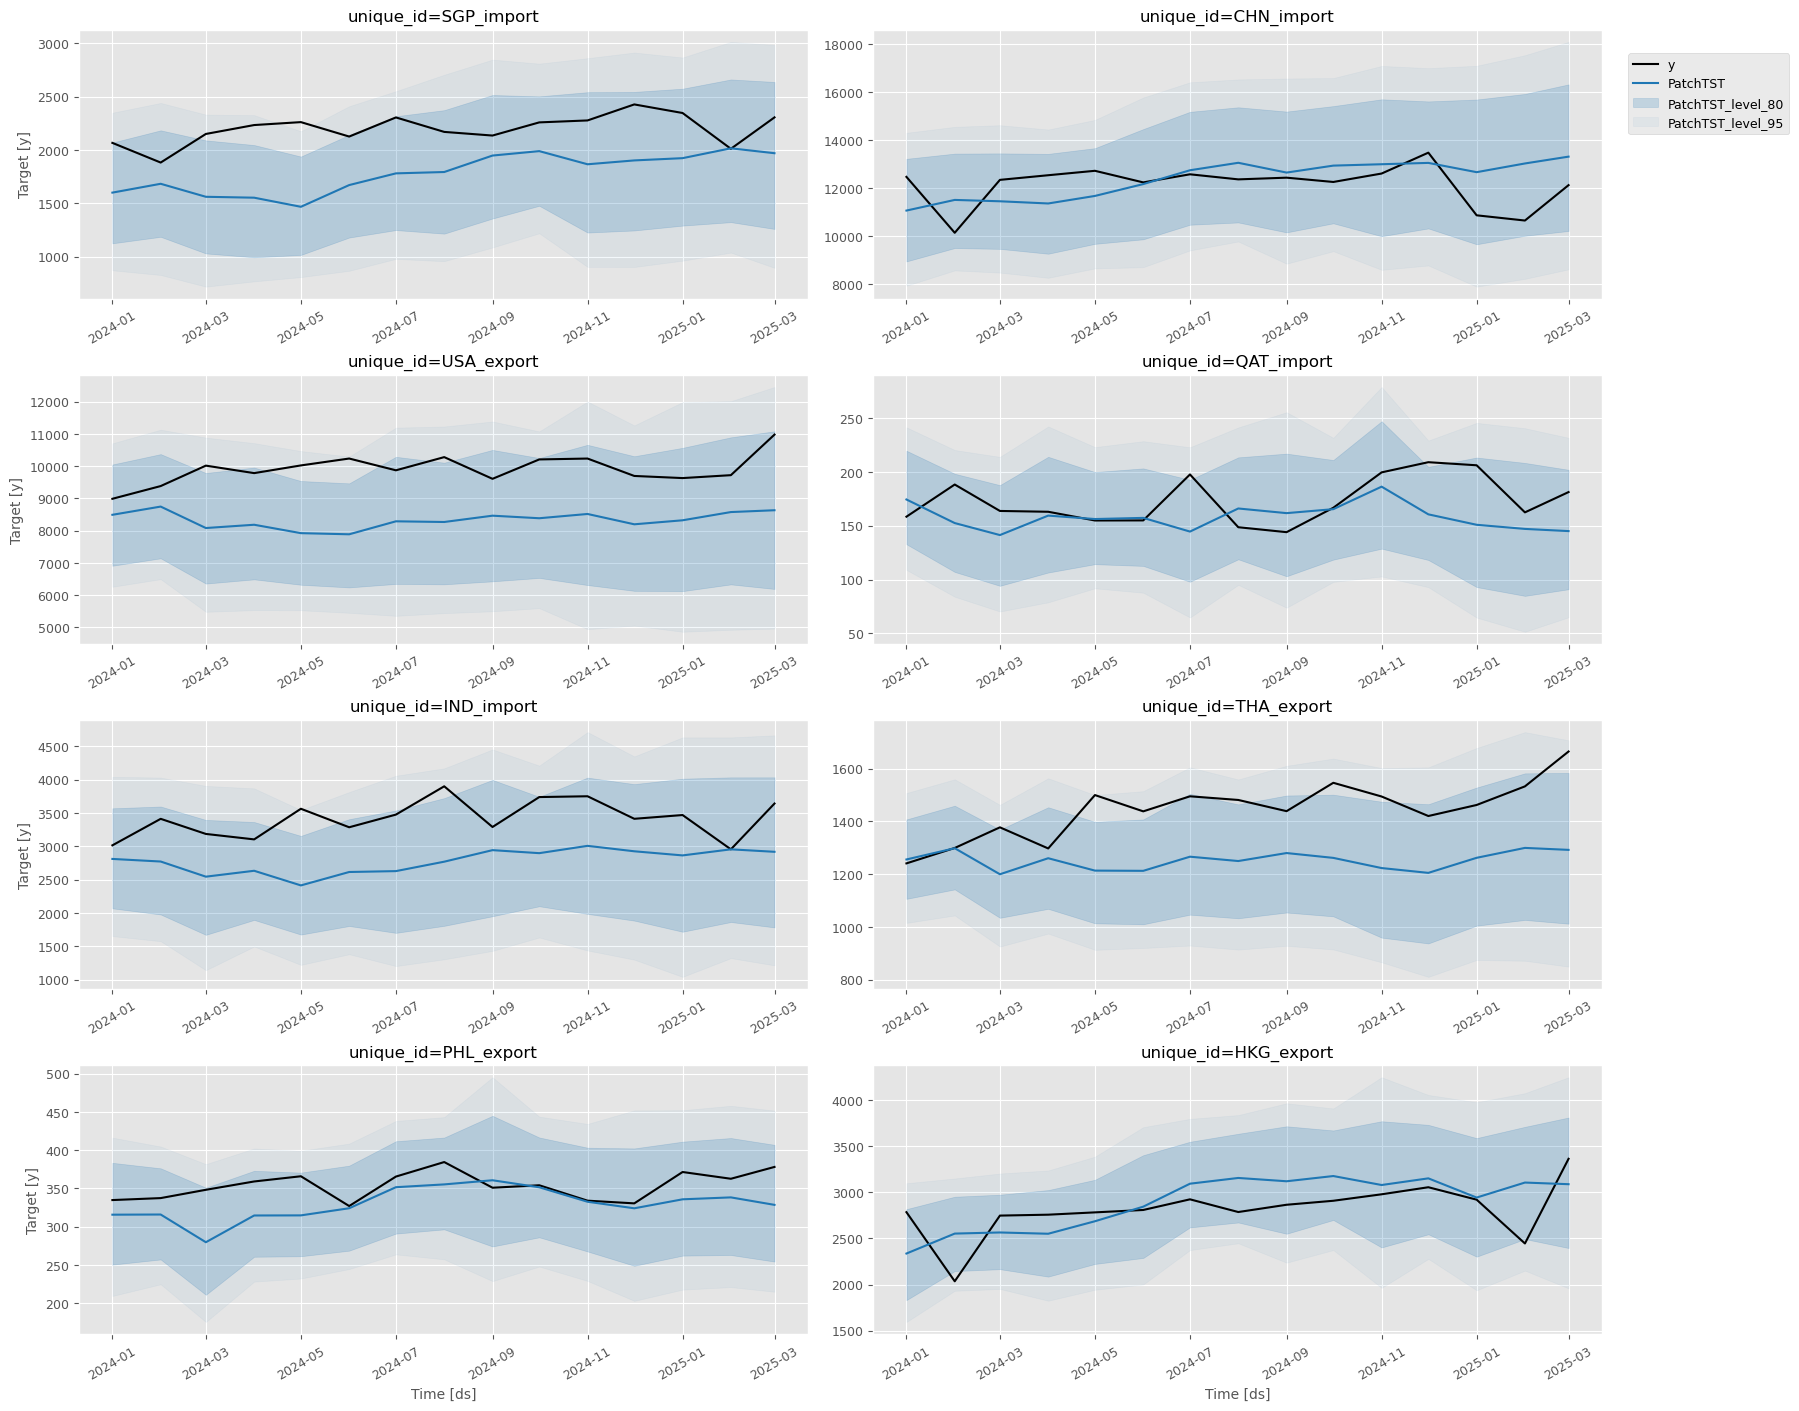

In [10]:
from utilsforecast.plotting import plot_series

custom_colors = ["black", "tab:blue"]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)
plot_series(DAT_TEST, df_f.drop(['PatchTST-median', 'y'], axis=1), level=[80, 95])

**Insights**
* Cross-validation results show that the PatchTST is the best MTL model for the dataset (Export, Import, FX) across all countries.
* The test set shows low MAE values of 25.35 Billion USD (for Ph Export) and 88 Billion USD (for Ph Import)
* Notably, the Prediction Intervals covers the test data for Ph Export.
* However, the MAE of the MTL is larger compared to STL models.
* Aggregating all inputs (Imports, Export, and FX) to one MTL model could introduce spurious relation which causes the model to overfit.

### 2.3 Import and Export Time Series In Isolation

We now try to evaluate the performance of the Deep Learning models using exclusive Import and Export Time series in the datasets.

#### Define Helper Functions

In [ ]:
h = len(DAT_TEST.ds.unique()) + 1
import gc

def run_evaluation(df_train, df_test, hist_exog_list = None, futr_exog_list = None, futur_df= None):
    from utilsforecast.losses import rmse, mae, mape as _mape, mase, rmsse
    gc.collect()    
    
    # TFT Supports all exogenous features, so always include it
    models = [TFT(
            h=h,
            input_size=2*h,
            hidden_size=128,
            n_head=4,
            loss=DistributionLoss(distribution='StudentT', level=[80, 95]),
            max_steps=200,  # keep small while testing
            hist_exog_list = hist_exog_list,
            futr_exog_list = futr_exog_list,
        ), ]
    
    # DeepAR Does not support historical exogenous features
    
    if (hist_exog_list == None):
        models.append(DeepAR(h=h,
                 input_size=2*h, #when predicting h, lookback 2*h
                 max_steps=500,
                 scaler_type='robust',
                 trajectory_samples=200,
                 loss=DistributionLoss(distribution='StudentT', level=[80, 95]),
                 lstm_n_layers=2, #By default this is 1
                 lstm_hidden_size=64,
                 decoder_hidden_layers=2, #MLP layers, we force it. Be default = 0, linear layer
                 decoder_hidden_size=64, 
                 futr_exog_list = futr_exog_list,
                 ))
         # PatchTST Does not support historical and future exogenous features
        if (futr_exog_list == None):
            models.append( PatchTST(
            h=h,
            input_size=4*h,
            max_steps=500,
            batch_size=32,
            hidden_size=64,
            n_heads=4,
            patch_len=16,
            stride=8,
            loss=DistributionLoss(distribution='Normal', level=[80, 95]),
            scaler_type='standard',
        )                   )
    for item in models:
        print(f'MODEL FOUND {str(item)}') 
    nf = NeuralForecast(models=models, freq='MS')
    nf.fit(df=df_train)
    print(f'MISSING {nf.get_missing_future(futur_df)}')
    df_f = nf.predict(futr_df = futur_df) # Forecast!
    df_f["ds"] = pd.to_datetime(df_f["ds"]).dt.to_period("M").dt.to_timestamp()
    df_f = pd.merge(df_test, df_f, on=['ds', 'unique_id']) # append ground truth "y"

    def mape(df, models, id_col="unique_id", target_col="y"):
        df_mape = _mape(df, models, id_col=id_col, target_col=target_col)
        df_mape.loc[:, df_mape.select_dtypes(include='number').columns] *= 100
        return df_mape


    df_eval = evaluate(df_f, 
                    metrics=[mae, rmse, mape, partial(mase, seasonality=12),
                                    partial(rmsse, seasonality=12)],
                    train_df=df_train) # mase uses snaive as scaler
    # df_eval.pivot(index='unique_id', columns='metric', values='DeepAR')
    return df_eval.pivot(index='unique_id', columns='metric', values=[str(x) for x in models])

# Highlight the best (lowest) MAE per unique_id in a grouped bar chart
def plot_results(model_eval):

    # Step 1: Reshape to long format
    df_long = (
        model_eval.stack(level=[0,1])
        .reset_index()
        .rename(columns={'level_1': 'model', 'level_2': 'metric', 0: 'value'})
    )

    # Step 2: Filter for MAE
    df_mae = df_long[df_long['metric'] == 'mae']

    # Step 3: Pivot (unique_id × model)
    pivot_mae = df_mae.pivot(index='unique_id', columns='model', values='value')

    # Step 4: Plot with distinct colors
    colors = plt.cm.Set2.colors[:len(pivot_mae.columns)]  # choose a nice colormap

    ax = pivot_mae.plot(kind='bar', figsize=(14,7), color=colors)

    ax.set_title("MAE Comparison Across Models")
    ax.set_ylabel("MAE (lower is better)")
    ax.set_xlabel("Unique ID")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

#### 2.3.1 Imports Only

In [ ]:
DAT_TRAIN_import = DAT_TRAIN[DAT_TRAIN['unique_id'].str.endswith('import')]
DAT_TEST_import = DAT_TEST[DAT_TEST['unique_id'].str.endswith('import')]

imports_eval = run_evaluation(DAT_TRAIN_import, DAT_TEST_import)

Seed set to 1
Seed set to 1
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K    

MODEL FOUND TFT
MODEL FOUND DeepAR
MODEL FOUND PatchTST


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | valid_loss   | MAE              | 0      | train
2 | padder_train | ConstantPad1d    | 0      | train
3 | scaler       | TemporalNorm     | 0      | train
4 | hist_encoder | LSTM             | 50.4 K | train
5 | decoder      | Decoder          | 4.4 K  | train
----------------------------------------------------------
54.8 K    Trainable params
5         Non-trainable params
54.8 K    Total params
0.219     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | DistributionLoss  | 5      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 167 K  | train
-----------------------------------------------------------
167 K     Trainable params
8         Non-trainable params
167 K     Total params
0.672     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_2217808/172040083.py:6: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  model_eval.stack(level=[0,1])
/tmp/ipykernel_2217808/172040083.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


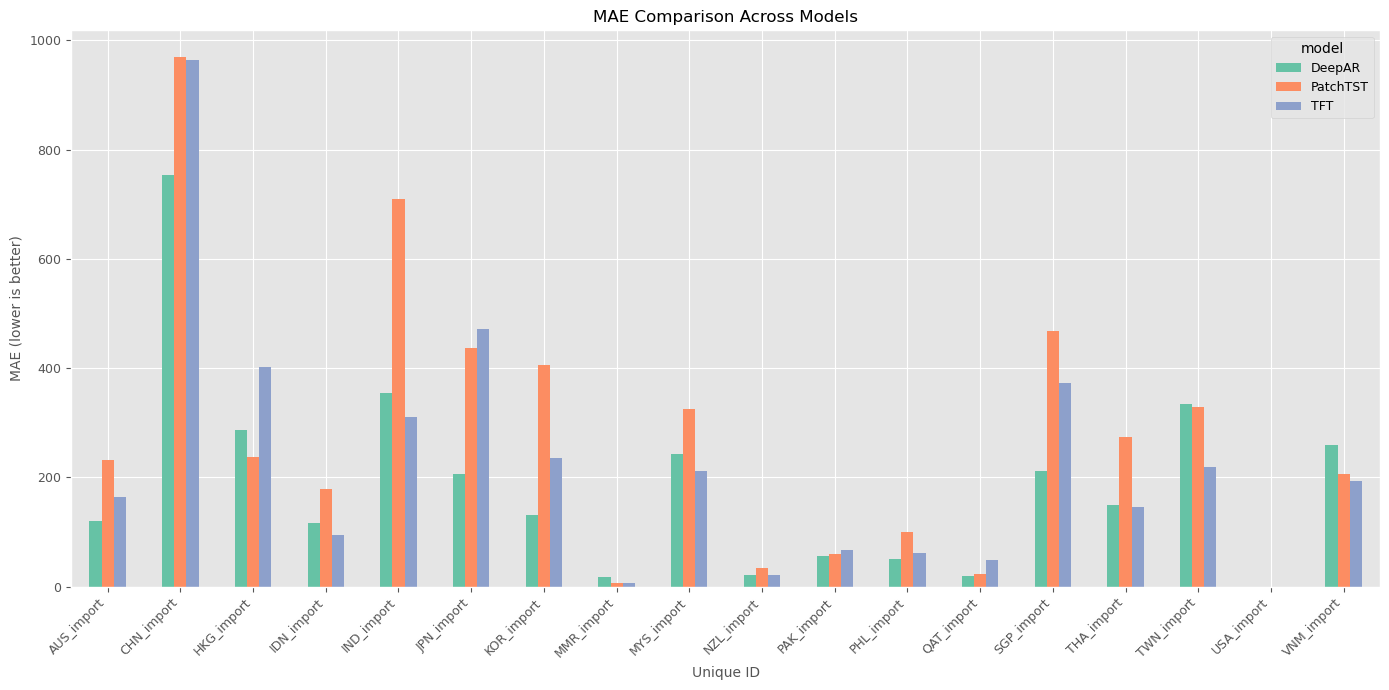

In [14]:
plot_results(imports_eval)

#### 2.3.2 Exports Only

In [15]:
DAT_TRAIN_export = DAT_TRAIN[DAT_TRAIN['unique_id'].str.endswith('export')]
DAT_TEST_export = DAT_TEST[DAT_TEST['unique_id'].str.endswith('export')]
exports_eval = run_evaluation(DAT_TRAIN_export, DAT_TEST_export)

Seed set to 1
Seed set to 1
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K    

MODEL FOUND TFT
MODEL FOUND DeepAR
MODEL FOUND PatchTST


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | valid_loss   | MAE              | 0      | train
2 | padder_train | ConstantPad1d    | 0      | train
3 | scaler       | TemporalNorm     | 0      | train
4 | hist_encoder | LSTM             | 50.4 K | train
5 | decoder      | Decoder          | 4.4 K  | train
----------------------------------------------------------
54.8 K    Trainable params
5         Non-trainable params
54.8 K    Total params
0.219     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | DistributionLoss  | 5      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 167 K  | train
-----------------------------------------------------------
167 K     Trainable params
8         Non-trainable params
167 K     Total params
0.672     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_2217808/172040083.py:6: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  model_eval.stack(level=[0,1])
/tmp/ipykernel_2217808/172040083.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


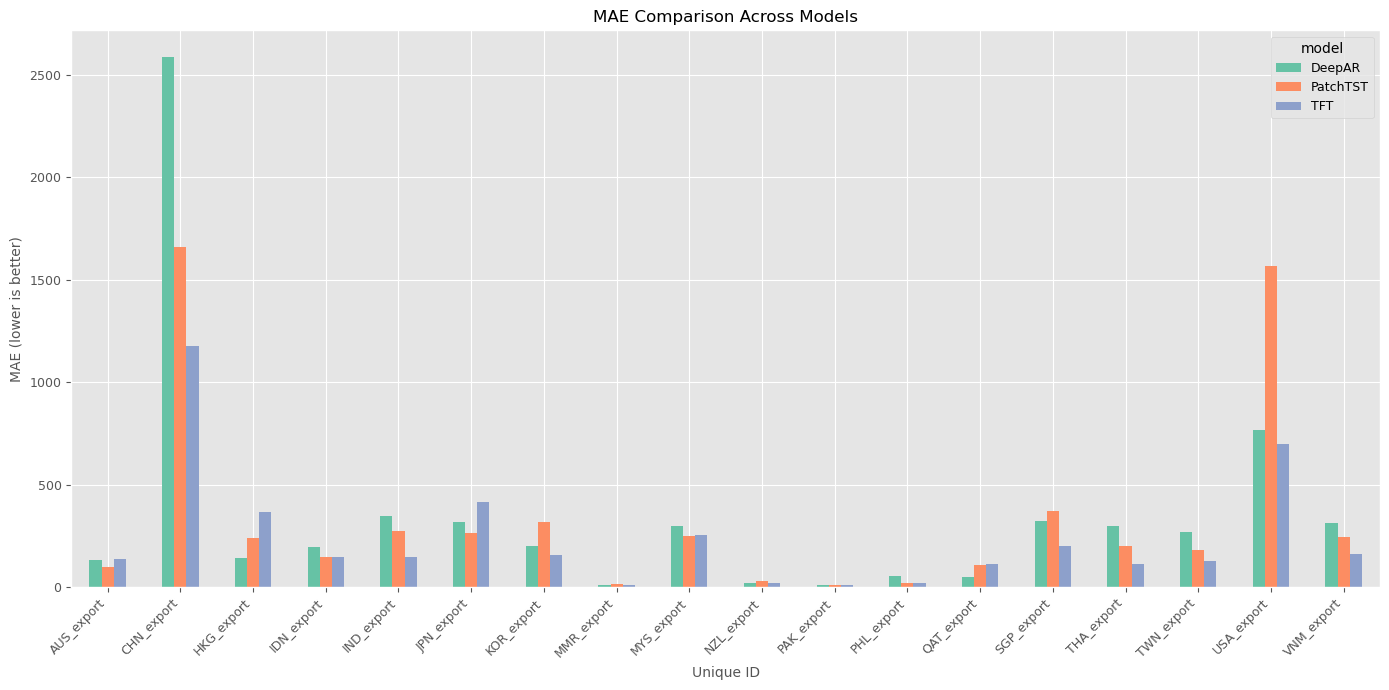

In [16]:
plot_results(exports_eval)

**Insights**
* DeepAR Performs best when forecasting Philippine imports for the Imports only dataset
* TFT performs best when forecasting Philippine exports using the exports only dataset.

In [17]:
# !pip install openpyxl

### 2.4 Import and Export plus Add Exogenous Variable: USD/PHP
We now try do add USD/PHP forex data into the time series features. The reasoning here is that imports/export could be correlated with the USD since international trade transactions are usually settled in USD, and a country's local currency strength agains the USD could be a factor in its import and export volumes. 

In [18]:
df_usd_php = pd.read_excel('./data/uscross_clean.xlsx')[['Date', 'PHL']].rename(columns={'Date': 'ds'})
df_usd_php

,ds,PHL
0,2010-01-01,0.022
1,2010-02-01,0.022
2,2010-03-01,0.022
3,2010-04-01,0.022
4,2010-05-01,0.022
...,...,...
182,2025-03-01,0.017
183,2025-04-01,0.018
184,2025-05-01,0.018
185,2025-06-01,0.018


In [19]:
DAT_TRAIN_export_curr = pd.merge(DAT_TRAIN_export, df_usd_php, on=['ds'] )
DAT_TRAIN_export_curr

DAT_TRAIN_import_curr = pd.merge(DAT_TRAIN_import, df_usd_php, on=['ds'] )
DAT_TRAIN_import_curr

,ds,unique_id,y,PHL
0,2010-01-01,USA_import,1.000,0.022
1,2010-02-01,USA_import,1.000,0.022
2,2010-03-01,USA_import,1.000,0.022
3,2010-04-01,USA_import,1.000,0.022
4,2010-05-01,USA_import,1.000,0.022
...,...,...,...,...
3019,2023-08-01,VNM_import,1606.879,0.018
3020,2023-09-01,VNM_import,1619.624,0.018
3021,2023-10-01,VNM_import,1621.277,0.018
3022,2023-11-01,VNM_import,1619.630,0.018


In [20]:
export_curr_eval = run_evaluation(DAT_TRAIN_export_curr, DAT_TEST_export, hist_exog_list=['PHL'])

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 768    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 696 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
954 K     Trainable params
5         Non-trainable params
954 K     Total params
3.817     Tota

MODEL FOUND TFT


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_2217808/172040083.py:6: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  model_eval.stack(level=[0,1])
/tmp/ipykernel_2217808/172040083.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


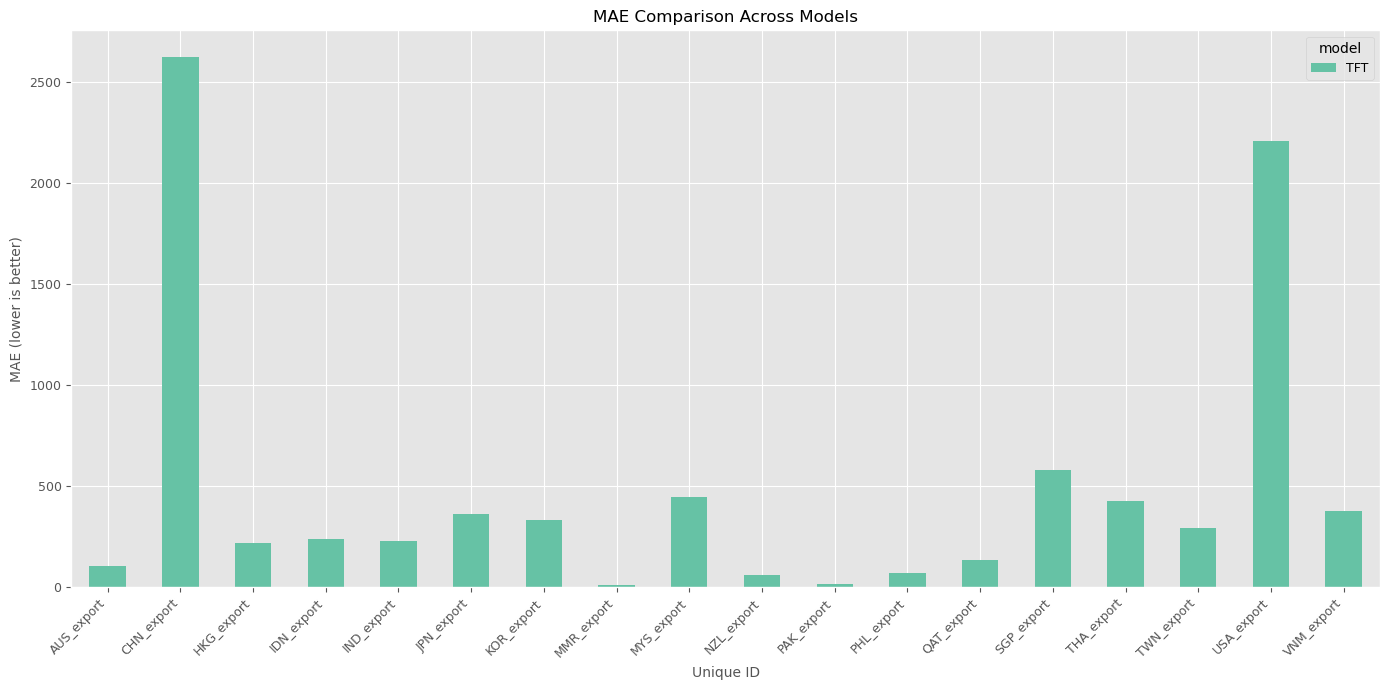

In [21]:
plot_results(export_curr_eval)

In [22]:
import_curr_eval = run_evaluation(DAT_TRAIN_import_curr, DAT_TEST_import, hist_exog_list=['PHL'])

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 768    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 696 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
954 K     Trainable params
5         Non-trainable params
954 K     Total params
3.817     Tota

MODEL FOUND TFT


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_2217808/172040083.py:6: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  model_eval.stack(level=[0,1])
/tmp/ipykernel_2217808/172040083.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


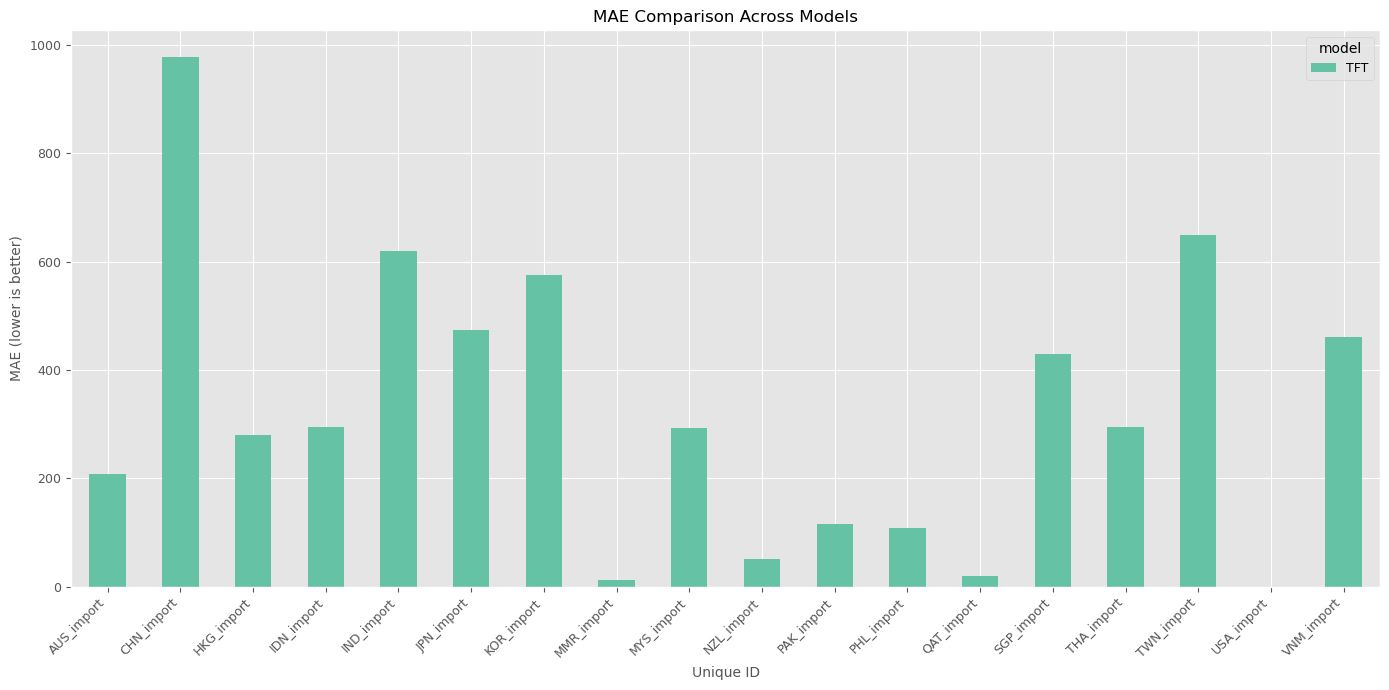

In [23]:
plot_results(import_curr_eval)

### 2.5 Import and Export With Top 4 Trading Partner Countries

Now let's consider only the top 4 countries that the Philippines does imports and exports with (i.e., Hongkong, Japan, China, Singapore). The reasoning here is that these countrues could have more of a correlation with the Philippines' imports and exports since they have stronger relationships with the country.

In [24]:
top4_export = ['HKG_export', 'JPN_export', 'CHN_export', 'SGP_export', 'PHL_export']
top4_import = ['HKG_import', 'JPN_import', 'CHN_import', 'SGP_import', 'PHL_import']

DAT_TRAIN_import_top4 = DAT_TRAIN_import[DAT_TRAIN_import['unique_id'].isin(top4_import)]
DAT_TRAIN_export_top4 = DAT_TRAIN_export[DAT_TRAIN_export['unique_id'].isin(top4_export)]

DAT_TEST_import_top4 = DAT_TEST_import[DAT_TEST_import['unique_id'].isin(top4_import)]
DAT_TEST_export_top4 = DAT_TEST_export[DAT_TEST_export['unique_id'].isin(top4_export)]


In [25]:
top4_export_eval = run_evaluation(DAT_TRAIN_export_top4, DAT_TEST_export_top4)

Seed set to 1
Seed set to 1
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K    

MODEL FOUND TFT
MODEL FOUND DeepAR
MODEL FOUND PatchTST


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | valid_loss   | MAE              | 0      | train
2 | padder_train | ConstantPad1d    | 0      | train
3 | scaler       | TemporalNorm     | 0      | train
4 | hist_encoder | LSTM             | 50.4 K | train
5 | decoder      | Decoder          | 4.4 K  | train
----------------------------------------------------------
54.8 K    Trainable params
5         Non-trainable params
54.8 K    Total params
0.219     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | DistributionLoss  | 5      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 167 K  | train
-----------------------------------------------------------
167 K     Trainable params
8         Non-trainable params
167 K     Total params
0.672     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_2217808/172040083.py:6: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  model_eval.stack(level=[0,1])
/tmp/ipykernel_2217808/172040083.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


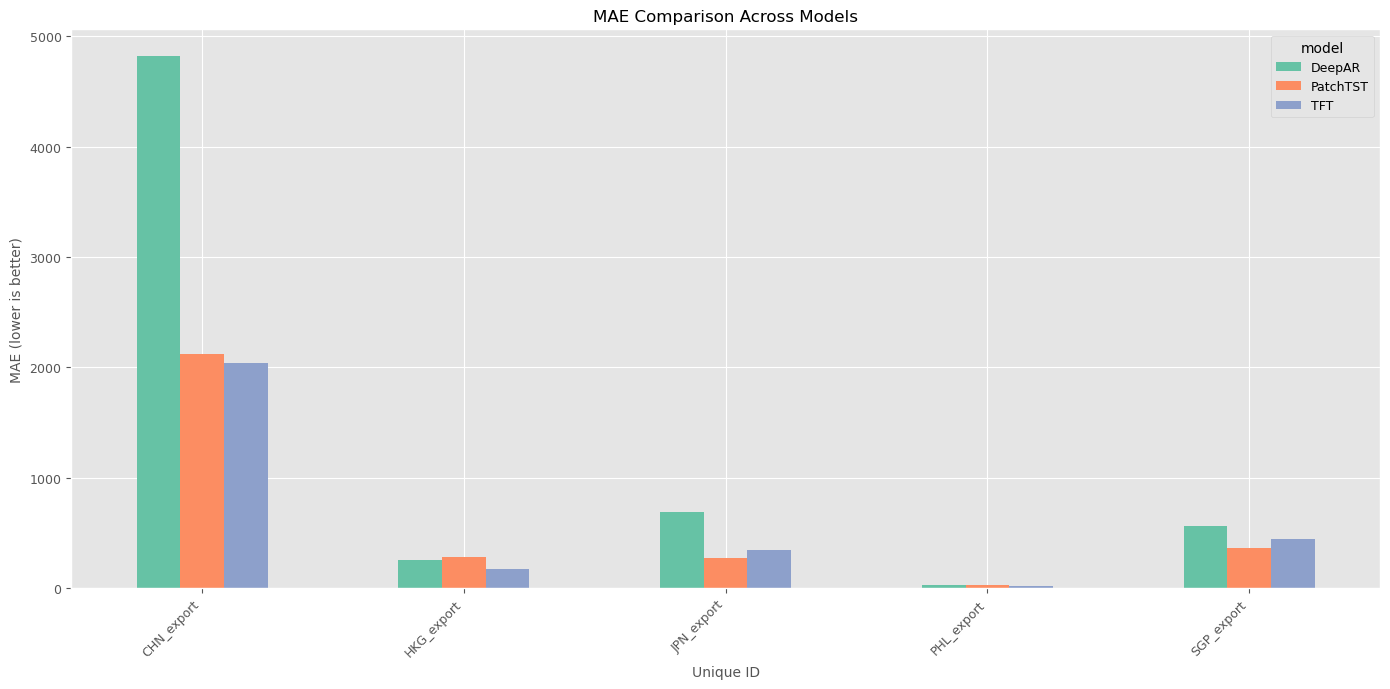

In [26]:
plot_results(top4_export_eval)

In [27]:
top4_import_eval = run_evaluation(DAT_TRAIN_import_top4, DAT_TEST_import_top4)

Seed set to 1
Seed set to 1
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K    

MODEL FOUND TFT
MODEL FOUND DeepAR
MODEL FOUND PatchTST


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | valid_loss   | MAE              | 0      | train
2 | padder_train | ConstantPad1d    | 0      | train
3 | scaler       | TemporalNorm     | 0      | train
4 | hist_encoder | LSTM             | 50.4 K | train
5 | decoder      | Decoder          | 4.4 K  | train
----------------------------------------------------------
54.8 K    Trainable params
5         Non-trainable params
54.8 K    Total params
0.219     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | DistributionLoss  | 5      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 167 K  | train
-----------------------------------------------------------
167 K     Trainable params
8         Non-trainable params
167 K     Total params
0.672     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_2217808/172040083.py:6: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  model_eval.stack(level=[0,1])
/tmp/ipykernel_2217808/172040083.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


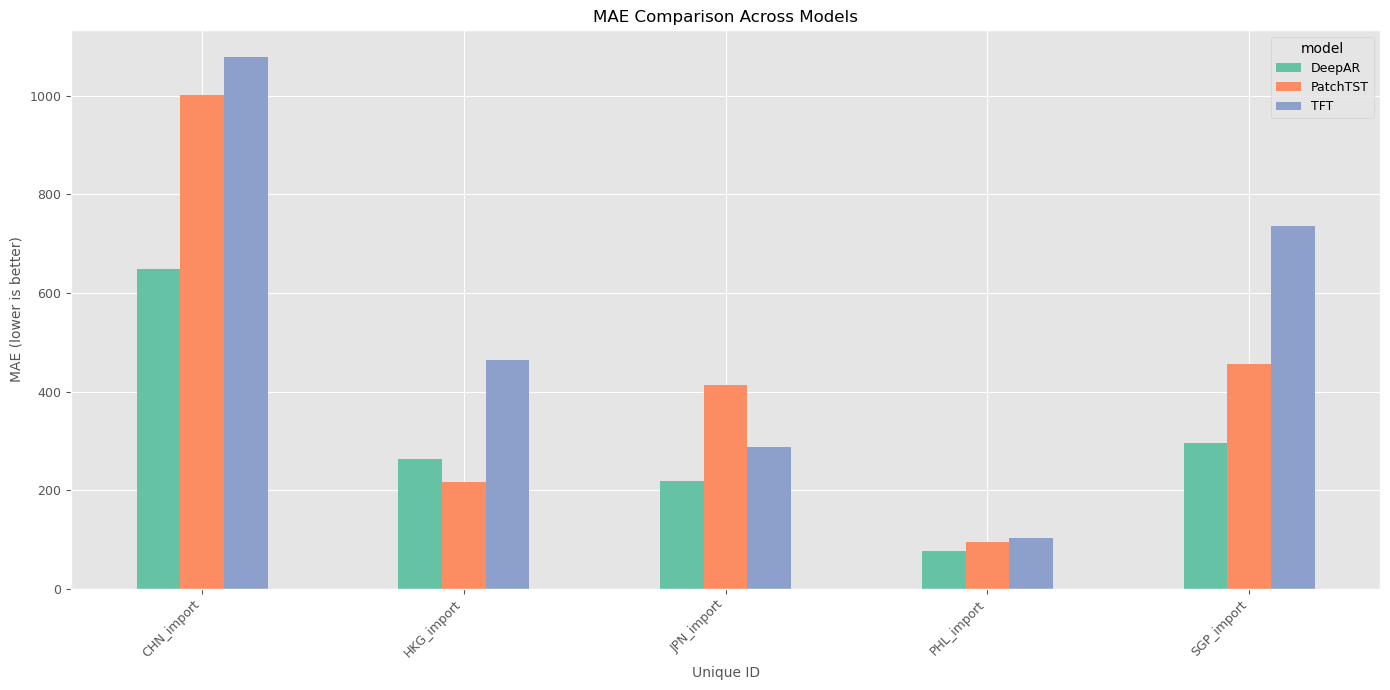

In [28]:
plot_results(top4_import_eval)

### 2.6 Import and Export With Top4 Trading Partner Countries plus FX(PHP/USD only)
Let's apply the USD/PHP feature to the previous datasets.

In [29]:
DAT_TRAIN_export_top4_curr = pd.merge(DAT_TRAIN_export_top4, df_usd_php, on=['ds'] )

DAT_TRAIN_import_top4_curr = pd.merge(DAT_TRAIN_import_top4, df_usd_php, on=['ds'] )
DAT_TRAIN_import_top4_curr

,ds,unique_id,y,PHL
0,2010-01-01,CHN_import,4389.967,0.022
1,2010-02-01,CHN_import,4028.260,0.022
2,2010-03-01,CHN_import,5460.584,0.022
3,2010-04-01,CHN_import,5291.872,0.022
4,2010-05-01,CHN_import,5125.352,0.022
...,...,...,...,...
835,2023-08-01,SGP_import,2057.616,0.018
836,2023-09-01,SGP_import,2049.517,0.018
837,2023-10-01,SGP_import,2152.238,0.018
838,2023-11-01,SGP_import,2042.797,0.018


In [30]:
top4_import_curr_eval = run_evaluation(DAT_TRAIN_import_top4_curr, DAT_TEST_import_top4, hist_exog_list=['PHL'])

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 768    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 696 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
954 K     Trainable params
5         Non-trainable params
954 K     Total params
3.817     Tota

MODEL FOUND TFT


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_2217808/172040083.py:6: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  model_eval.stack(level=[0,1])
/tmp/ipykernel_2217808/172040083.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


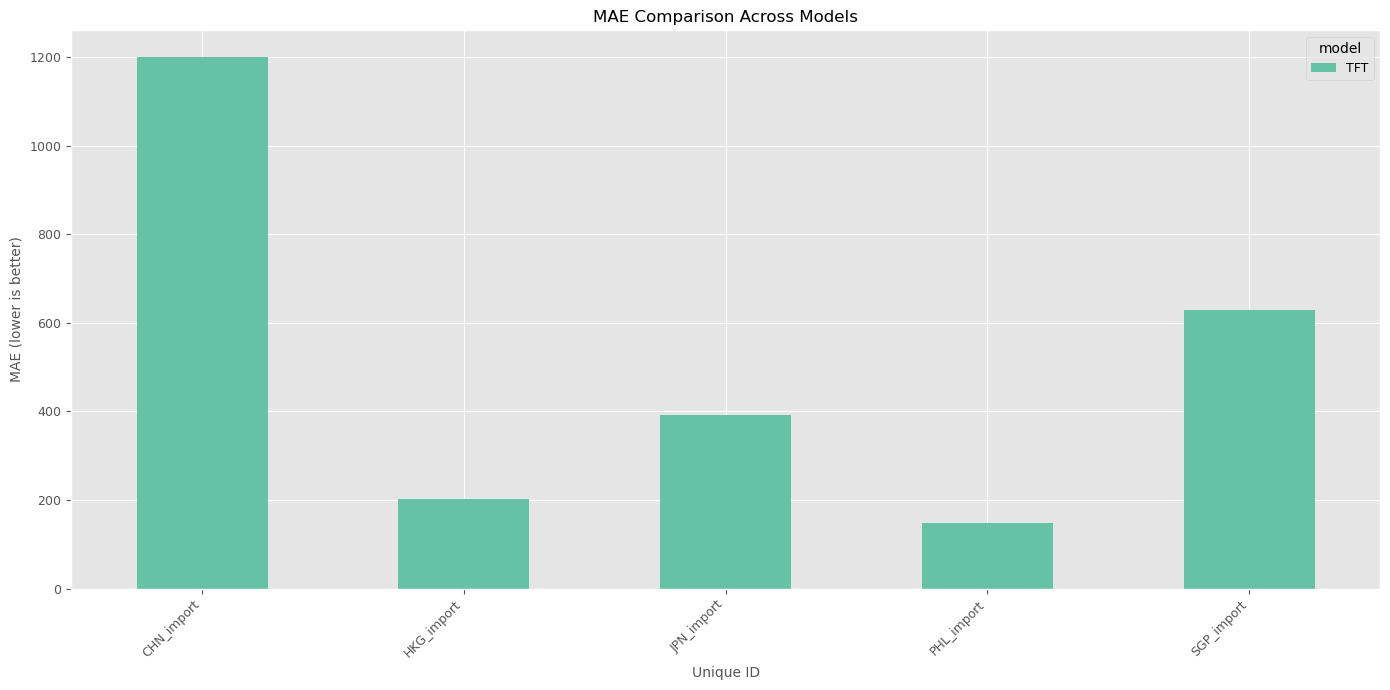

In [31]:
plot_results(top4_import_curr_eval)

In [33]:
top4_export_curr_eval = run_evaluation(DAT_TRAIN_export_top4_curr, DAT_TEST_export_top4, hist_exog_list=['PHL'])

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 768    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 696 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
954 K     Trainable params
5         Non-trainable params
954 K     Total params
3.817     Tota

MODEL FOUND TFT


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_2217808/172040083.py:6: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  model_eval.stack(level=[0,1])
/tmp/ipykernel_2217808/172040083.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


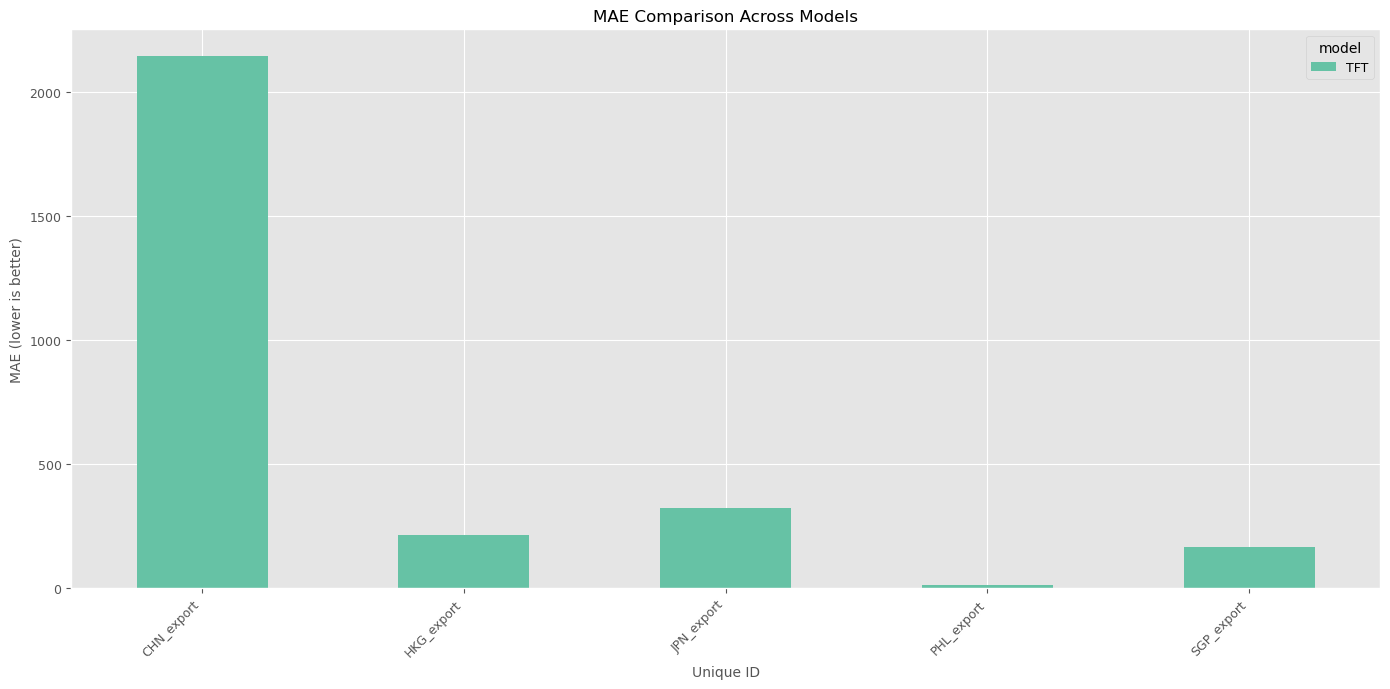

In [34]:
plot_results(top4_export_curr_eval)

In [129]:
def extract_best_model(df):
    results = {}
    models = df.columns.to_list()
    models = list(set([x for (x, y) in models]))
    # print(models)

    # loop through all unique_ids that start with 'PHL'
    for uid in df.index:
        if uid.startswith("PHL"):
            mae_values = dict([
                (x, df.loc[uid, (x, "mae")]) for x in models
            ])

            # pick best model by lowest mae
            best_model = min(mae_values, key=mae_values.get)

            # collect all metrics for the best model
            best_metrics = df.loc[uid, best_model].to_dict()

            results[uid] = {"best_model": best_model, "metrics": best_metrics}

    return results

Summarizing:

### 2.7 Models 2.5 and 2.6 with Fourier terms.
Now we add some context to the forecast by adding static covariates. This would capture country-specific and time-specific trends.



In [110]:
### (b) features DeepAR
from functools import partial
from utilsforecast.feature_engineering import fourier, time_features, pipeline

features = [
    partial(fourier, season_length = 12, k=2),
    partial(time_features, features = ['month'])
]

df_train, df_futr = pipeline(
    DAT_TRAIN,
    features = features,
    freq = 'MS',
    h=h
)

df_train




,ds,unique_id,y,sin1_12,sin2_12,cos1_12,cos2_12,month
0,2010-01-01,AUS_export,618.538,5.000e-01,8.660e-01,8.660e-01,0.5,1
1,2010-02-01,AUS_export,613.971,8.660e-01,8.660e-01,5.000e-01,-0.5,2
2,2010-03-01,AUS_export,699.770,1.000e+00,-8.742e-08,-4.371e-08,-1.0,3
3,2010-04-01,AUS_export,769.386,8.660e-01,-8.660e-01,-5.000e-01,-0.5,4
4,2010-05-01,AUS_export,829.484,5.000e-01,-8.660e-01,-8.660e-01,0.5,5
...,...,...,...,...,...,...,...,...
6043,2023-08-01,VNM_import,1606.879,-8.660e-01,8.660e-01,-5.000e-01,-0.5,8
6044,2023-09-01,VNM_import,1619.624,-1.000e+00,-1.709e-06,8.544e-07,-1.0,9
6045,2023-10-01,VNM_import,1621.277,-8.660e-01,-8.660e-01,5.000e-01,-0.5,10
6046,2023-11-01,VNM_import,1619.630,-5.000e-01,-8.660e-01,8.660e-01,0.5,11


In [99]:
df_futr

,unique_id,ds,sin1_12,sin2_12,cos1_12,cos2_12,month
0,AUS_export,2024-01-01,5.000e-01,8.660e-01,8.660e-01,0.5,1
1,AUS_export,2024-02-01,8.660e-01,8.660e-01,5.000e-01,-0.5,2
2,AUS_export,2024-03-01,1.000e+00,-4.268e-06,-2.134e-06,-1.0,3
3,AUS_export,2024-04-01,8.660e-01,-8.660e-01,-5.000e-01,-0.5,4
4,AUS_export,2024-05-01,5.000e-01,-8.660e-01,-8.660e-01,0.5,5
...,...,...,...,...,...,...,...
571,VNM_import,2024-12-01,2.385e-07,4.770e-07,1.000e+00,1.0,12
572,VNM_import,2025-01-01,5.000e-01,8.660e-01,8.660e-01,0.5,1
573,VNM_import,2025-02-01,8.660e-01,8.660e-01,5.000e-01,-0.5,2
574,VNM_import,2025-03-01,1.000e+00,-9.386e-06,-4.693e-06,-1.0,3


In [146]:
fel = ['sin1_12', 'sin2_12', 'cos1_12', 'cos2_12', 'month']

Let's add Fourier Terms to our evaluations, as well as the base featured dataset for completeness.

In [37]:
base_features_eval = run_evaluation(DAT_TRAIN, DAT_TEST)

Seed set to 1
Seed set to 1
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 512    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 613 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
870 K     Trainable params
5         Non-trainable params
870 K    

MODEL FOUND TFT
MODEL FOUND DeepAR
MODEL FOUND PatchTST


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | valid_loss   | MAE              | 0      | train
2 | padder_train | ConstantPad1d    | 0      | train
3 | scaler       | TemporalNorm     | 0      | train
4 | hist_encoder | LSTM             | 50.4 K | train
5 | decoder      | Decoder          | 4.4 K  | train
----------------------------------------------------------
54.8 K    Trainable params
5         Non-trainable params
54.8 K    Total params
0.219     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | DistributionLoss  | 5      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 167 K  | train
-----------------------------------------------------------
167 K     Trainable params
8         Non-trainable params
167 K     Total params
0.672     Total estimated model params size (MB)
90        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
fourier_terms_eval = run_evaluation(df_train, DAT_TEST, futur_df=df_futr,  futr_exog_list=fel)

Seed set to 1
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 1.5 K  | train
4 | temporal_encoder        | TemporalCovariateEncoder | 1.3 M  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
1.5 M     Trainable params
5         Non-trainable params
1.5 M     Total params


MODEL FOUND TFT
MODEL FOUND DeepAR


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | valid_loss   | MAE              | 0      | train
2 | padder_train | ConstantPad1d    | 0      | train
3 | scaler       | TemporalNorm     | 0      | train
4 | hist_encoder | LSTM             | 51.7 K | train
5 | decoder      | Decoder          | 4.4 K  | train
----------------------------------------------------------
56.1 K    Trainable params
5         Non-trainable params
56.1 K    Total params
0.224     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MISSING Empty DataFrame
Columns: [unique_id, ds]
Index: []


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Let's try Fourier Terms + Forex:

In [144]:
df_train_curr = pd.merge(df_train, df_usd_php, on=['ds'] )
df_train_curr


,ds,unique_id,y,sin1_12,sin2_12,cos1_12,cos2_12,month,PHL
0,2010-01-01,AUS_export,618.538,5.000e-01,8.660e-01,8.660e-01,0.5,1,0.022
1,2010-02-01,AUS_export,613.971,8.660e-01,8.660e-01,5.000e-01,-0.5,2,0.022
2,2010-03-01,AUS_export,699.770,1.000e+00,-8.742e-08,-4.371e-08,-1.0,3,0.022
3,2010-04-01,AUS_export,769.386,8.660e-01,-8.660e-01,-5.000e-01,-0.5,4,0.022
4,2010-05-01,AUS_export,829.484,5.000e-01,-8.660e-01,-8.660e-01,0.5,5,0.022
...,...,...,...,...,...,...,...,...,...
6043,2023-08-01,VNM_import,1606.879,-8.660e-01,8.660e-01,-5.000e-01,-0.5,8,0.018
6044,2023-09-01,VNM_import,1619.624,-1.000e+00,-1.709e-06,8.544e-07,-1.0,9,0.018
6045,2023-10-01,VNM_import,1621.277,-8.660e-01,-8.660e-01,5.000e-01,-0.5,10,0.018
6046,2023-11-01,VNM_import,1619.630,-5.000e-01,-8.660e-01,8.660e-01,0.5,11,0.018


In [147]:
fourier_terms_curr_eval = run_evaluation(df_train_curr, DAT_TEST, futur_df=df_futr,  hist_exog_list=['PHL'], futr_exog_list=fel)

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 1.8 K  | train
4 | temporal_encoder        | TemporalCovariateEncoder | 1.4 M  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
1.6 M     Trainable params
5         Non-trainable params
1.6 M     Total params
6.508     Tota

MODEL FOUND TFT


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MISSING Empty DataFrame
Columns: [unique_id, ds]
Index: []


Predicting: |          | 0/? [00:00<?, ?it/s]

Apply Fourier Terms on Top 4

In [155]:
df_train_top4_export, df_futr_top4_export = pipeline(
    DAT_TRAIN_export_top4,
    features = features,
    freq = 'MS',
    h=h
)

df_train_top4_import, df_futr_top4_import = pipeline(
    DAT_TRAIN_import_top4,
    features = features,
    freq = 'MS',
    h=h
)


In [156]:
top4_export_fourier_eval = run_evaluation(df_train_top4_export, DAT_TEST_export_top4, futur_df=df_futr_top4_export, futr_exog_list=fel)
top4_import_fourier_eval = run_evaluation(df_train_top4_import, DAT_TEST_import_top4, futur_df=df_futr_top4_import, futr_exog_list=fel)

Seed set to 1
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 1.5 K  | train
4 | temporal_encoder        | TemporalCovariateEncoder | 1.3 M  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
1.5 M     Trainable params
5         Non-trainable params
1.5 M     Total params


MODEL FOUND TFT
MODEL FOUND DeepAR


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | valid_loss   | MAE              | 0      | train
2 | padder_train | ConstantPad1d    | 0      | train
3 | scaler       | TemporalNorm     | 0      | train
4 | hist_encoder | LSTM             | 51.7 K | train
5 | decoder      | Decoder          | 4.4 K  | train
----------------------------------------------------------
56.1 K    Trainable params
5         Non-trainable params
56.1 K    Total params
0.224     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MISSING Empty DataFrame
Columns: [unique_id, ds]
Index: []


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 1.5 K  | train
4 | temporal_encoder        | TemporalCovariateEncoder | 1.3 M  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
1.5 M     Trainable params
5         Non-trainable params
1.5 M     Total params


MODEL FOUND TFT
MODEL FOUND DeepAR


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | valid_loss   | MAE              | 0      | train
2 | padder_train | ConstantPad1d    | 0      | train
3 | scaler       | TemporalNorm     | 0      | train
4 | hist_encoder | LSTM             | 51.7 K | train
5 | decoder      | Decoder          | 4.4 K  | train
----------------------------------------------------------
56.1 K    Trainable params
5         Non-trainable params
56.1 K    Total params
0.224     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MISSING Empty DataFrame
Columns: [unique_id, ds]
Index: []


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Add Forex

In [157]:
df_train_top4_export_curr = pd.merge(df_train_top4_export, df_usd_php, on=['ds'] )

df_train_top4_import_curr = pd.merge(df_train_top4_import, df_usd_php, on=['ds'] )

In [158]:
top4_export_fourier_curr_eval = run_evaluation(df_train_top4_export_curr, DAT_TEST_export_top4, futur_df=df_futr_top4_export, futr_exog_list=fel, hist_exog_list=['PHL'])
top4_import_fourier_curr_eval = run_evaluation(df_train_top4_import_curr, DAT_TEST_import_top4, futur_df=df_futr_top4_import, futr_exog_list=fel, hist_exog_list=['PHL'])

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 1.8 K  | train
4 | temporal_encoder        | TemporalCovariateEncoder | 1.4 M  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
1.6 M     Trainable params
5         Non-trainable params
1.6 M     Total params
6.508     Tota

MODEL FOUND TFT


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MISSING Empty DataFrame
Columns: [unique_id, ds]
Index: []


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 1.8 K  | train
4 | temporal_encoder        | TemporalCovariateEncoder | 1.4 M  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
1.6 M     Trainable params
5         Non-trainable params
1.6 M     Total params
6.508     Tota

MODEL FOUND TFT


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MISSING Empty DataFrame
Columns: [unique_id, ds]
Index: []


Predicting: |          | 0/? [00:00<?, ?it/s]

Summarizing:

In [159]:

evaluations = {
    "All Timeseries on PHL Exports": extract_best_model(base_features_eval)['PHL_export'],
    "All Timeseries on PHL Imports": extract_best_model(base_features_eval)['PHL_import'],
    "All Timeseries With Fourier Terms on PHL Exports": extract_best_model(fourier_terms_eval)['PHL_export'],
    "All Timeseries With Fourier Terms on PHL Imports": extract_best_model(fourier_terms_eval)['PHL_import'],
    "All Timeseries With Fourier Terms and Forex on PHL Exports": extract_best_model(fourier_terms_curr_eval)['PHL_export'],
    "All Timeseries With Fourier Terms and Forex on PHL Imports": extract_best_model(fourier_terms_curr_eval)['PHL_import'],
    "Exports Only": extract_best_model(exports_eval)['PHL_export'],
    "Imports Only": extract_best_model(imports_eval)['PHL_import'],
    "Exports Only With Forex": extract_best_model(export_curr_eval)['PHL_export'],
    "Imports Only With Forex": extract_best_model(import_curr_eval)['PHL_import'],
    "Top 4 Exports Only": extract_best_model(top4_export_eval)['PHL_export'],
    "Top 4 Imports Only": extract_best_model(top4_import_eval)['PHL_import'],
    "Top 4 Exports Only With Forex": extract_best_model(top4_export_curr_eval)['PHL_export'],
    "Top 4 Imports Only With Forex": extract_best_model(top4_import_curr_eval)['PHL_import'],
    "Top 4 Exports Only With Fourier Terms": extract_best_model(top4_export_fourier_eval)['PHL_export'],
    "Top 4 Imports Only With Fourier Terms": extract_best_model(top4_import_fourier_eval)['PHL_import'],
    "Top 4 Exports Only With Fourier Terms and Forex": extract_best_model(top4_export_fourier_curr_eval)['PHL_export'],
    "Top 4 Imports Only With Fourier Terms and Forex": extract_best_model(top4_import_fourier_curr_eval)['PHL_import'],
    
}

In [160]:
df_eval = df = pd.DataFrame.from_dict(
    {k: {"best_model": v["best_model"], **v["metrics"]} for k,v in evaluations.items()},
    orient="index"
).sort_values("mae")
df_eval

,best_model,mae,mape,mase,rmse,rmsse
Top 4 Exports Only With Forex,TFT,13.032,3.759,0.448,16.870,0.433
All Timeseries on PHL Exports,DeepAR,16.224,4.704,0.558,19.666,0.505
Top 4 Exports Only,TFT,20.305,5.932,0.698,25.646,0.659
Exports Only,PatchTST,21.508,5.954,0.740,28.836,0.740
Top 4 Imports Only With Fourier Terms,DeepAR,26.106,4.369,0.426,35.294,0.421
Top 4 Exports Only With Fourier Terms,TFT,26.576,7.521,0.914,29.341,0.753
All Timeseries With Fourier Terms on PHL Exports,DeepAR,29.838,8.666,1.026,36.621,0.940
Top 4 Exports Only With Fourier Terms and Forex,TFT,33.851,9.526,1.164,40.663,1.044
All Timeseries With Fourier Terms and Forex on PHL Exports,TFT,35.635,9.929,1.225,40.821,1.048
All Timeseries With Fourier Terms on PHL Imports,DeepAR,37.483,6.224,0.612,44.435,0.530


Based on the evaluation data, these are the best Deep Learing methods to use:
* Philippine Exports - TFT using Top 4 export partners with forex data at MAE of 13.0 Billion USD
* Philippine Imports - DeepAR using Top 4 import partners with  fourier terms with MAE of 26 Billion USD.

## 3.0 Visualization of MTL best forecast

In [161]:
h = len(DAT_TEST.ds.unique()) + 1

models = [TFT(
            h=h,
            input_size=2*h,
            hidden_size=128,
            n_head=4,
            loss=DistributionLoss(distribution='StudentT', level=[80, 95]),
            max_steps=200,  # keep small while testing
            hist_exog_list = ['PHL'],
            futr_exog_list = None,
        ), ]

nf = NeuralForecast(models=models, freq='M')
nf.fit(df=DAT_TRAIN_export_top4_curr)

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                    | Type                     | Params | Mode 
-----------------------------------------------------------------------------
0 | loss                    | DistributionLoss         | 5      | train
1 | padder_train            | ConstantPad1d            | 0      | train
2 | scaler                  | TemporalNorm             | 0      | train
3 | embedding               | TFTEmbedding             | 768    | train
4 | temporal_encoder        | TemporalCovariateEncoder | 696 K  | train
5 | temporal_fusion_decoder | TemporalFusionDecoder    | 256 K  | train
6 | output_adapter          | Linear                   | 387    | train
-----------------------------------------------------------------------------
954 K     Trainable params
5         Non-trainable params
954 K     Total params
3.817     Tota

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.


In [162]:
df_f = nf.predict()

/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/home/andy/miniconda3/envs/tsa_final_project/lib/python3.12/site-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Text(0.5, 1.0, 'Philippine Exports Forecast Using TFT on the Top 4 Export Partners and Forex Data')

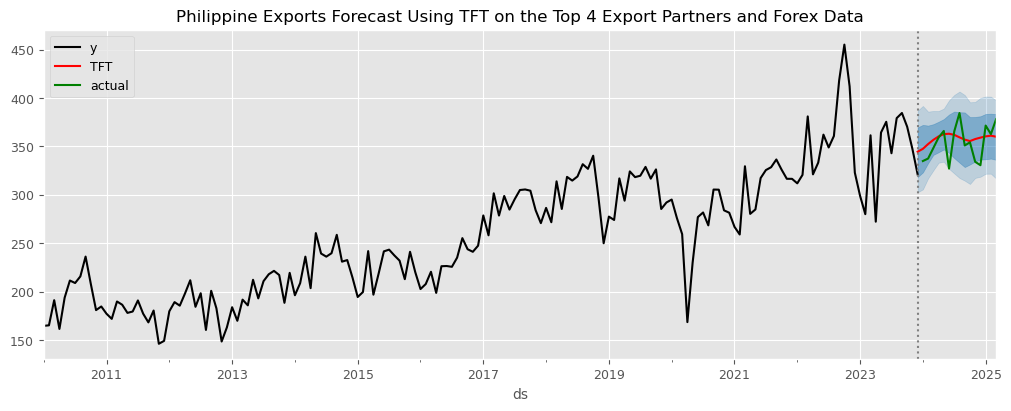

In [210]:
fig, ax = plt.subplots()
df_f["ds"] = pd.to_datetime(df_f["ds"])
# convert to matplotlib datetime numbers
x = df_f["ds"].values.astype("datetime64[ns]")
df_f = df_f.loc[df_f['unique_id']=='PHL_export']
DAT_TRAIN_export.loc[DAT_TRAIN_export['unique_id']=='PHL_export'].plot(ax=ax, x='ds', y='y', color='black')
df_f.plot(ax=ax, x='ds', y='TFT', color="red")
DAT_TEST_export.loc[DAT_TEST_export['unique_id']=='PHL_export'].plot(ax=ax, x='ds', y='y', label='actual', color="green")
ax.fill_between(x, df_f['TFT-lo-95'], df_f['TFT-hi-95'], color='tab:blue', alpha = 0.2)
ax.fill_between(x, df_f['TFT-lo-80'], df_f['TFT-hi-80'], color='tab:blue', alpha = 0.4)
plt.axvline(x=df_f['ds'].iloc[0], color='grey', linestyle='dotted')
plt.title('Philippine Exports Forecast Using TFT on the Top 4 Export Partners and Forex Data')


**Insights**:
* The TFT was able to capture the general trend of Ph export.
* The 80% Prediction Intervals cover the actual next 15 month PH export activity.
* The MAE from TFT is well below the STL models (13.03 versus 20.34 Billion USD)
* The MTL forecast shows an improvement of 36 percent in MAE ((MTL/STL - 1)*100)

In [214]:
h = len(DAT_TEST.ds.unique()) + 1

models = [DeepAR(h=h,
                 input_size=2*h, #when predicting h, lookback 2*h
                 max_steps=500,
                 scaler_type='robust',
                 trajectory_samples=200,
                 loss=DistributionLoss(distribution='StudentT', level=[80, 95]),
                 lstm_n_layers=2, #By default this is 1
                 lstm_hidden_size=64,
                 decoder_hidden_layers=2, #MLP layers, we force it. Be default = 0, linear layer
                 decoder_hidden_size=64, 
                 futr_exog_list = fel,
                 )]

nf = NeuralForecast(models=models, freq='MS')
nf.fit(df=df_train_top4_import)

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | loss         | DistributionLoss | 5      | train
1 | valid_loss   | MAE              | 0      | train
2 | padder_train | ConstantPad1d    | 0      | train
3 | scaler       | TemporalNorm     | 0      | train
4 | hist_encoder | LSTM             | 51.7 K | train
5 | decoder      | Decoder          | 4.4 K  | train
----------------------------------------------------------
56.1 K    Trainable params
5         Non-trainable params
56.1 K    Total params
0.224     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.


In [216]:
df_f = nf.predict(futr_df = df_futr_top4_import)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Text(0.5, 1.0, 'Philippine Imports Forecast Using DeepAR on the Top 4 Import Partners and Fourier Terms')

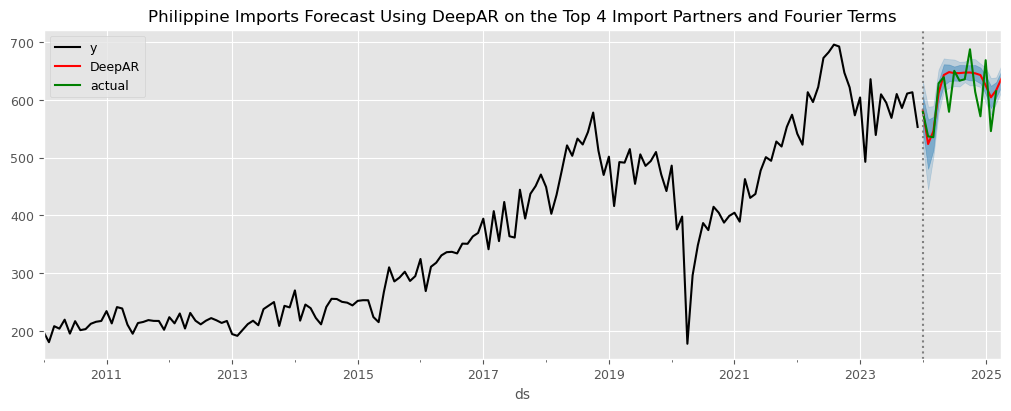

In [218]:
fig, ax = plt.subplots()
df_f["ds"] = pd.to_datetime(df_f["ds"])
# convert to matplotlib datetime numbers
x = df_f["ds"].values.astype("datetime64[ns]")
df_f = df_f.loc[df_f['unique_id']=='PHL_import']
DAT_TRAIN_import.loc[DAT_TRAIN_import['unique_id']=='PHL_import'].plot(ax=ax, x='ds', y='y', color='black')
df_f.plot(ax=ax, x='ds', y='DeepAR', color="red")
DAT_TEST_import.loc[DAT_TEST_import['unique_id']=='PHL_import'].plot(ax=ax, x='ds', y='y', label='actual', color="green")
ax.fill_between(x, df_f['DeepAR-lo-95'], df_f['DeepAR-hi-95'], color='tab:blue', alpha = 0.2)
ax.fill_between(x, df_f['DeepAR-lo-80'], df_f['DeepAR-hi-80'], color='tab:blue', alpha = 0.4)
plt.axvline(x=df_f['ds'].iloc[0], color='grey', linestyle='dotted')
plt.title('Philippine Imports Forecast Using DeepAR on the Top 4 Import Partners and Fourier Terms')

**Insights**:
* The DeepAR was able to capture the general trend of Ph import.
* The PI of DeepAR is narrower compared to the PI from the best STL model for Ph imports.
* The 95% PI does not cover the actual next 15 month PH import activity suggesting that the model was confidently wrong in its forecast.
* The MAE from DeepAR is well below the STL models (26.11 versus 38 Billion USD)
* The MTL forecast shows an improvement of 33 percent in MAE ((MTL/STL - 1)*100)

## 4.0 Summary and Conclusion

We highlight 5 key findings in the MTL exercise.

* **Model Selection Matters by Task** TFT performs best for Philippine exports forecasting (MAE: 13.0B USD) while DeepAR excels at imports forecasting (MAE: 26.1B USD), demonstrating that different deep learning architectures have varying strengths for specific time series patterns.

* **Feature Engineering Significantly Improves Performance**. Adding USD/PHP forex data and Fourier terms to capture seasonality substantially reduces forecasting errors, with the best models incorporating both exogenous variables and engineered features rather than vanilla implementations.

* **Focused Datasets Outperform Global Models**. Using only the top 4 trading partners (Hong Kong, Japan, China, Singapore) produces better forecasts than including all countries, suggesting that spurious correlations from aggregating all imports/exports can cause overfitting.

* **Deep Learning Shows Substantial Improvement Over Statistical Models**. The best MTL models achieve 36% improvement for exports and 33% improvement for imports compared to STL models, with MAEs dropping from 20.34B to 13.03B USD for exports and 38B to 26.11B USD for imports.

* **Prediction Intervals Reveal Model Confidence Issues**. While TFT's 80% prediction intervals properly cover actual export values, DeepAR's narrower intervals for imports fail to capture actual values, indicating the model was "confidently wrong" despite having lower MAE. This requires further investigation.

Thus, MTL shows superior performance for forecasting Philippines exports and imports activity with up to 36 percent improvement in MAE against STL models.
Data from other countries help regularize the model by supplementing the model with more information enabling a production of a single global model for trade for dfferent countries.
Central Banks and statistical agencies may consider Multi-task/Global forecasting models as part of their forecasting tool.
